In [208]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import datetime
from scipy.optimize import curve_fit
import matplotlib.dates as mdates
from matplotlib.lines import Line2D

In [294]:
SMALL_DT = 64
COLORS = ['black', 'grey', 'lightgrey', 'lightcoral', 'brown', 'maroon', 'red', 'salmon', 'crimson', 'peru', 'navajowhite', 'orange', 'gold', 'yellow', 'darkkhaki', 'chartreuse', 'green', 'olive', 'springgreen', 'aqua', 'teal', 'darkgreen', 'deepskyblue', 'navy', 'blue', 'indigo', 'mediumpurple', 'purple', 'violet', 'magenta', 'hotpink', 'pink']

In [12]:
def open_datacube(directory):
    with xr.open_dataset(directory, decode_timedelta=False) as ds:
        data = ds
    return data

In [22]:
def select_in_range(data, start, end):
    return data.where(data.mid_date>np.datetime64(start)).where(data.mid_date<np.datetime64(end))

In [320]:
def get_images_and_vel(cube, x, y): # get the velocities and img1 and img2 dates for an x, y coordinate
    vels = []
    img1s = []
    img2s = []
    for md in gl_cube.mid_date.values:
        img1 = cube.acquisition_img2.sel(mid_date=md).values
        img2 = cube.acquisition_img1.sel(mid_date=md).values
        if type(img1) == np.ndarray:
            img1 = cube.acquisition_img2.sel(mid_date=md).values[0]
            img2 = cube.acquisition_img1.sel(mid_date=md).values[0]
        vel_val = cube.v.sel(x=cube.x[x], y=cube.y[y], mid_date=md).values
        vel = vel_val
        
        if vel_val.size > 1:
            for v in vel_val:
                if not np.isnan(v):
                    vel = v
        if type(vel) == np.ndarray and vel.size > 1:
            vel = vel[0]
        if type(vel) == np.ndarray and vel.size==1:
            vel = vel.item()
        vels.append(vel)
        img1s.append(img1)
        img2s.append(img2)
    return np.array(vels), np.array(img1s), np.array(img2s)

In [319]:
def plotting_timespan(xmin, xmax, y):
    plt.figure(figsize=(20,5))
    plt.hlines(y, xmin, xmax, color='red')
    plt.show()
    
def plotting_timespan_color_coded(xmin, xmax, y): #horizontal lines, color coded for dts
    dts = (xmax-xmin)
    small_dt = np.timedelta64(SMALL_DT, 'D').astype('timedelta64[ns]')
    col = np.where(dts<small_dt, 'r', 'lightblue')
    plt.figure(figsize=(20,5))
    plt.hlines(y, xmin, xmax, color=col)
    handles, labels = plt.gca().get_legend_handles_labels()
    blueline = Line2D([0], [0], label = f'dt > {SMALL_DT} days',color='lightblue')
    redline = Line2D([0], [0], label = f'dt < {SMALL_DT} days',color='r')
    handles.extend([blueline,redline])
    plt.legend(handles=handles)
    plt.show()

In [318]:
def plotting_by_month(data): # pass in an xarray DataArray
    sorted_data = data.sortby('mid_date')
    all_vel = sorted_data.dropna('mid_date')
    all_dates = all_vel.mid_date.values.astype('M8[ms]').astype('O')
    all_times = np.array(list(map(datetime.date.toordinal, all_dates)))

    year = all_dates[0].year
    end_year = all_dates[-1].year
    i = 0

    fig, ax = plt.subplots(figsize=(20, 5))
    month_day_fmt = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_formatter(month_day_fmt)
    min_year = 1987
    color = 5
    legend_colors = []
    while year <= end_year:
        if i > len(all_dates)-1:
            break
        if all_dates[i].year != year:
            year = all_dates[i].year
            color += 1
        date = datetime.datetime(2000, all_dates[i].month, all_dates[i].day, all_dates[i].hour, all_dates[i].minute, all_dates[i].second, all_dates[i].microsecond)
        if all_dates[i].year in legend_colors:
            plt.scatter(date, all_vel.values[i], c=COLORS[all_dates[i].year - min_year])
        else:
            plt.scatter(date, all_vel.values[i], c=COLORS[all_dates[i].year - min_year], label=all_dates[i].year)
            legend_colors.append(all_dates[i].year)
        i+=1
    plt.legend()
    plt.show()

In [317]:
def plotting_by_months(vel, mid_date): # pass in numpy arrays
    def make_same_year(date):
        return datetime.datetime(2000, date.month, date.day, date.hour, date.minute, date.second, date.microsecond)

    mid_dates, vels = (np.array(t) for t in zip(*sorted(zip(mid_date, vel))))
    min_year = min(mid_dates).year

    fig, ax = plt.subplots(figsize=(20, 5))
    month_day_fmt = mdates.DateFormatter('%d %b')
    ax.xaxis.set_major_formatter(month_day_fmt)

    legend_colors = []
    for i in range(len(vels)):
        date = make_same_year(mid_dates[i])
        #print(mid_dates[i].year - min_year)
        if mid_dates[i].year in legend_colors:
            plt.scatter(date, vels[i], c=COLORS[mid_dates[i].year - min_year])
        else:
            plt.scatter(date, vels[i], c=COLORS[mid_dates[i].year - min_year], label=mid_dates[i].year)
            legend_colors.append(mid_dates[i].year)
    plt.legend()
    plt.show()

In [321]:
def select_by_dt(vels, img1s, img2s, short_dt=True): # filter out long (default) or short dts
    dts = img2s-img1s
    small_dt = np.timedelta64(SMALL_DT, 'D').astype('timedelta64[ns]')
    if short_dt:
        new_vels = np.array([vels[i] for i in range(len(vels)) if dts[i] < small_dt])
        new_img1s = np.array([img1s[i] for i in range(len(img1s)) if dts[i] < small_dt])
        new_img2s = np.array([img2s[i] for i in range(len(img2s)) if dts[i] < small_dt])
    else:
        new_vels = np.array([vels[i] for i in range(len(vels)) if dts[i] > small_dt])
        new_img1s = np.array([img1s[i] for i in range(len(img1s)) if dts[i] > small_dt])
        new_img2s = np.array([img2s[i] for i in range(len(img2s)) if dts[i] > small_dt])
    return new_vels, new_img1s, new_img2s

In [13]:
greenland_dir = 'Greenland_61.6N_48.1W.nc'
gl_cube = open_datacube(greenland_dir)

In [14]:
gl_cube

<xarray.Dataset>
Dimensions:                    (mid_date: 7073, x: 416, y: 416)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2012-12-30T00:00:00....
  * x                          (x) float64 6.04e+05 6.042e+05 ... 7.036e+05
  * y                          (y) float64 6.887e+06 6.887e+06 ... 6.788e+06
Data variables: (12/42)
    UTM_Projection             object ...
    acquisition_img1           (mid_date) datetime64[ns] ...
    acquisition_img2           (mid_date) datetime64[ns] ...
    autoRIFT_software_version  (mid_date) float64 ...
    chip_size_height           (mid_date, y, x) float32 ...
    chip_size_width            (mid_date, y, x) float32 ...
    ...                         ...
    vy                         (mid_date, y, x) float32 ...
    vy_error                   (mid_date) float64 ...
    vy_stable_shift            (mid_date) float64 ...
    vyp                        (mid_date, y, x) float32 ...
    vyp_error                  (mid_date) float64 ...
    vyp_stable_shift           (mid_date) float64 ...
Attributes:
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    datacube_software_version:  1.0
    date_created:               21-06-2021 18:10:46
    date_updated:               21-06-2021 18:10:46
    institution:                NASA Jet Propulsion Laboratory (JPL), Califor...
    projection:                 32622
    title:                      ITS_LIVE datacube of image_pair velocities

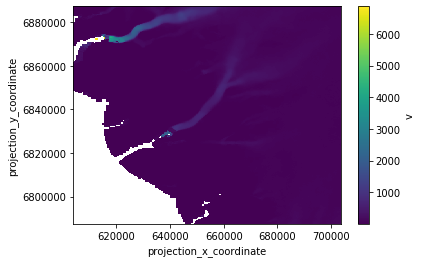

In [20]:
gl_median = gl_cube.v.median(dim='mid_date')
gl_median.plot(x='x', y='y')
plt.show()

Spatial plot of the median velocities for the Greenland data cube.

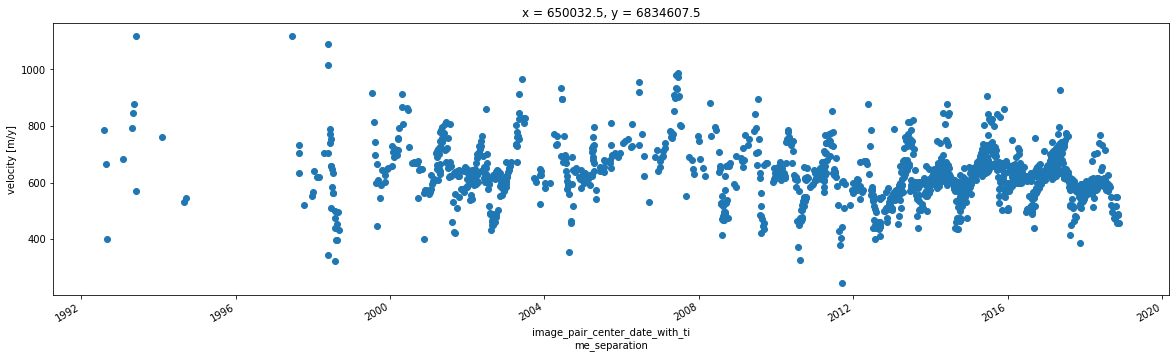

In [175]:
x_coord = 192 # x coord of grid cell
y_coord = 219 # y coord of grid cell

grid_cell_v = gl_cube.v.isel(x=x_coord, y=y_coord)
grid_cell_v.plot(marker='o', linestyle="None", figsize=(20, 5))
plt.show()

Plot of all the velocities of the grid cell through time. 

In [167]:
grid_cell_v

<xarray.DataArray 'v' (mid_date: 7073)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * mid_date  (mid_date) datetime64[ns] 2012-12-30T00:00:00.171000064 ... 201...
    x         float64 6.5e+05
    y         float64 6.835e+06
Attributes:
    best_practice:  velocities should always be merged/averaged using compone...
    description:    velocity magnitude
    grid_mapping:   UTM_Projection
    standard_name:  velocity
    units:          m/y

In [168]:
min_year = pd.to_datetime(min(grid_cell_v.mid_date.values)).year
max_year = pd.to_datetime(max(grid_cell_v.mid_date.values)).year

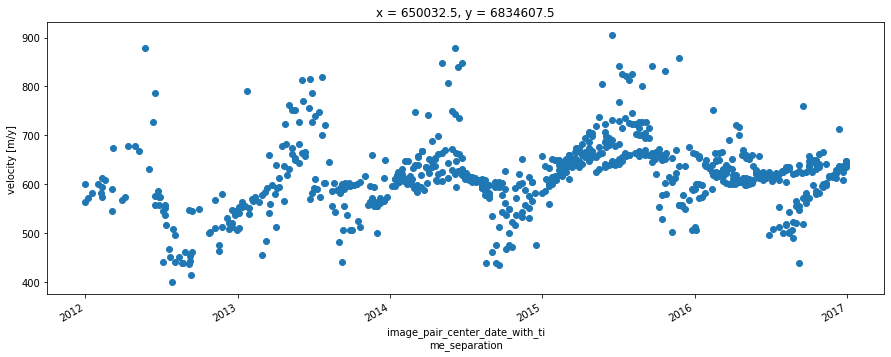

In [169]:
v_in_range = select_in_range(grid_cell_v, "2012", "2017")
v_in_range.plot(marker='o', linestyle="None", figsize=(15, 5))
plt.show()

Velocity at the grid cell between 2012 and 2017

In [305]:
vels, img1s, img2s = get_images_and_vel(gl_cube, x_coord, y_coord)

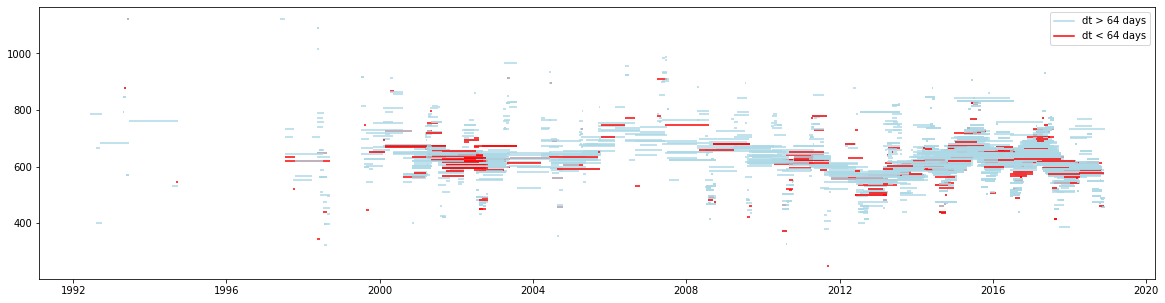

In [306]:
plotting_timespan_color_coded(img1s, img2s, vels)

Seasonal grid cell: Plotting the velocity with horizontal lines to represent the dt length. The red lines show a shorter dt.

In [223]:
mid_x = int(len(gl_cube.x)/2)
mid_y = int(len(gl_cube.y)/2)
vels1, img1s1, img2s1 = get_images_and_vel(gl_cube, mid_x, mid_y)

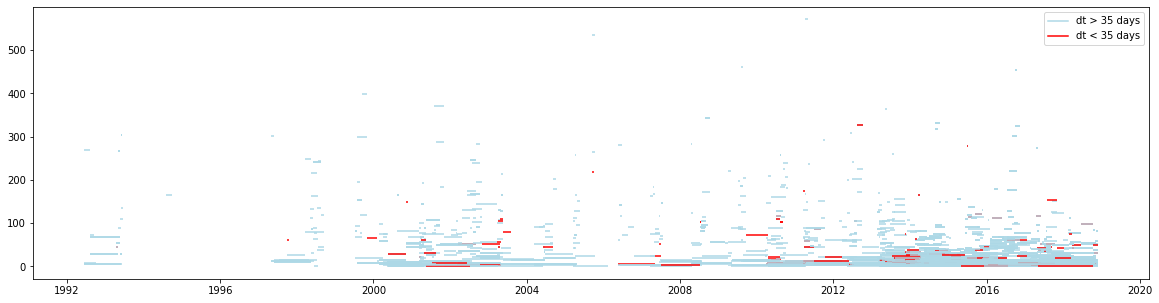

In [233]:
plotting_timespan_color_coded(img1s1, img2s1, vels1)

Mid grid cell: Plotting the velocity with horizontal lines to represent the dt length. The red lines show a shorter dt.

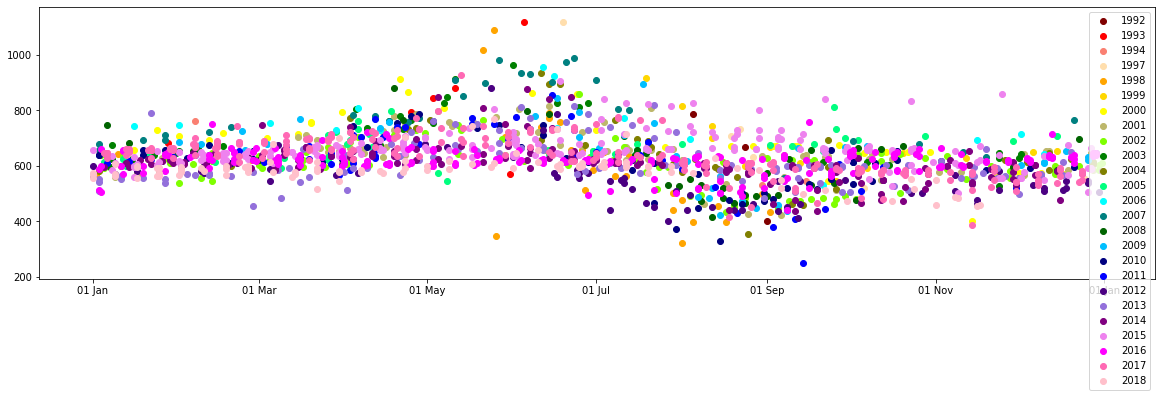

In [315]:
plotting_by_month(grid_cell_v)

Plotted the seasonal trends for all velocities

In [307]:
new_vels, new_img1s, new_img2s = select_by_dt(vels, img1s, img2s)

In [308]:
mid_dates = ((new_img2s-new_img1s)/2 + new_img1s).astype('M8[ms]').astype('O')

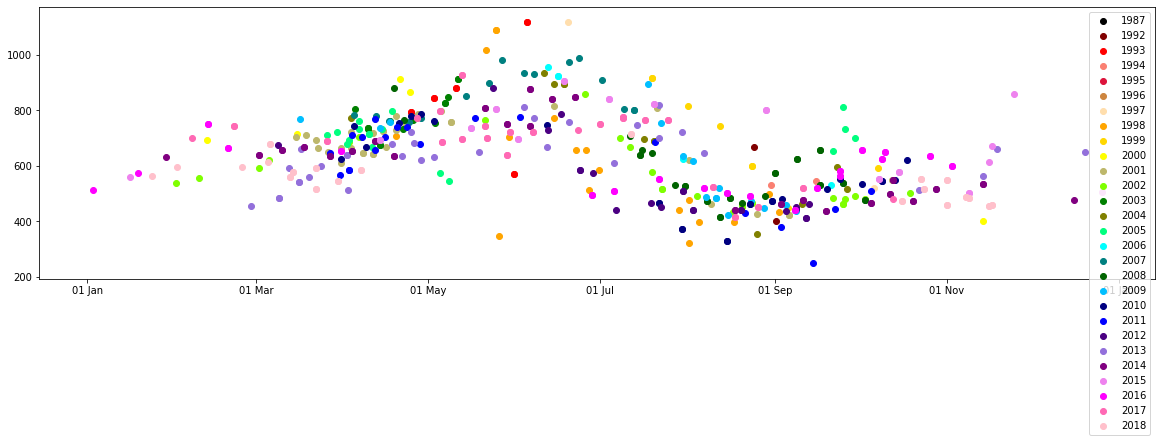

In [316]:
plotting_by_months(new_vels, mid_dates)

Plotted the seasonal trends for the shorter dt velocities